# Pycaret

In [1]:
!pip install -U pandas-profiling
!pip install pycaret
!pip install markupsafe==2.0.1
!pip install optuna
!pip install catboost
!pip install wandb
!pip install editdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsaf

In [2]:
import os
import random
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold

from pycaret.regression import *

import re
import editdistance

import warnings
warnings.filterwarnings('ignore')

import argparse
import wandb
wandb.init(project="DACON_235901", name="pycaret")

parser = argparse.ArgumentParser(description="pycaret")
parser.add_argument('--ensemble', default="blending", type=str) # blending or stacking
parser.add_argument('--best_n', default=8, type=int)
parser.add_argument('--scaler', default="standard", type=str) # standard or minmax
parser.add_argument('--tune_iter', default=10, type=int)
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

ensemble = args.ensemble
best_n = args.best_n
tune_iter = args.tune_iter
scaler = args.scaler
cv = args.cv
seed = args.seed

if scaler == "standard":
    scaler="zscore"
elif scaler == "minmax":
    scaler="minmax"

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

train = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/test.csv")

train.head()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
wandb: Currently logged in as: gnoeyheat. Use `wandb login --relogin` to force relogin


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


### Pandas Profiling

In [3]:
pr = train.profile_report()
pr

Output hidden; open in https://colab.research.google.com to view.

## Preprocessing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


In [5]:
train.describe()

,id,odometer,year,target
count,1015.000000,1015.000000,1015.000000,1.015000e+03
mean,507.000000,116842.121182,2008.385222,8.243204e+06
std,293.149564,105162.545836,35.592123,1.239567e+07
min,0.000000,0.000000,1217.000000,4.000000e+05
25%,253.500000,55918.000000,2006.000000,2.535000e+06
50%,507.000000,94972.000000,2010.000000,4.215000e+06
75%,760.500000,153224.000000,2014.000000,8.927500e+06
max,1014.000000,987322.000000,2020.000000,1.500150e+08


In [6]:
train.describe(include="object")

,title,location,isimported,engine,transmission,fuel,paint
count,1015,1015,1015,1015,1015,1015,1015
unique,203,13,3,8,2,2,76
top,Toyota Camry,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black
freq,129,792,744,618,965,970,292


In [7]:
def TargetEncoder(variable, statistics, train, test):
    if statistics=="mean":
        target_dict = dict(train.groupby(by=variable).mean()["target"])
    elif statistics=="median":
        target_dict = dict(train.groupby(by=variable).median()["target"])
    elif statistics=="ordinal":
        target_dict = dict(train.groupby(by=variable).mean()["target"])
        target_dict = dict(pd.Series(np.arange(1, len(target_dict)+1), index=pd.Series(target_dict).sort_values().index))

    train[variable] = [target_dict[k] for k in train[variable]]

    temp=[]
    for k in test[variable]:
        if k in target_dict:
            temp.append(target_dict[k])
        else:
            if statistics=="mean":
                temp.append(np.mean(list(target_dict.values())))
            elif statistics=="median":
                temp.append(np.median(list(target_dict.values())))

    test[variable] = temp

    print(target_dict)

    return train, test

### target

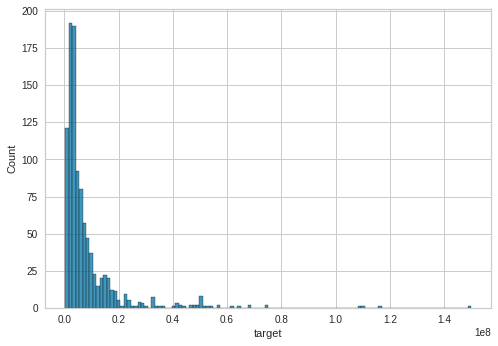

In [8]:
sns.histplot(train["target"])
plt.show()

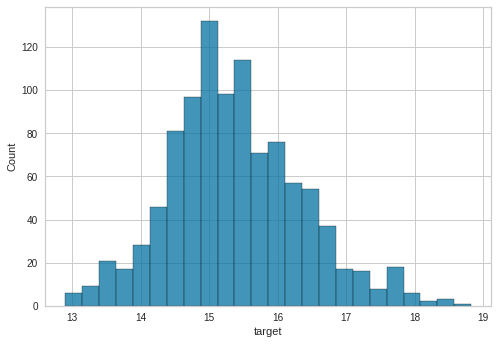

In [9]:
train["target"] = np.log(train["target"])
sns.histplot(train["target"])
plt.show()

### odometer

In [10]:
odometer_median = train["odometer"].median()

train["odometer"] = train["odometer"].replace(0, odometer_median)
test["odometer"] = test["odometer"].replace(0, odometer_median)

train["odometer"].min(), test["odometer"].min()

(10, 38)

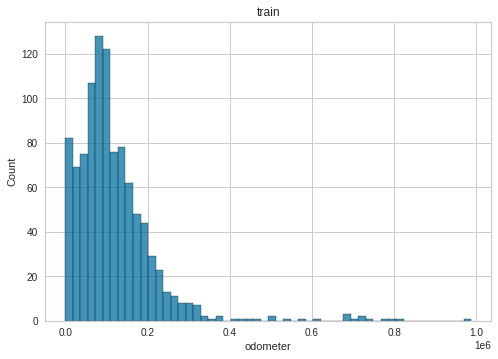

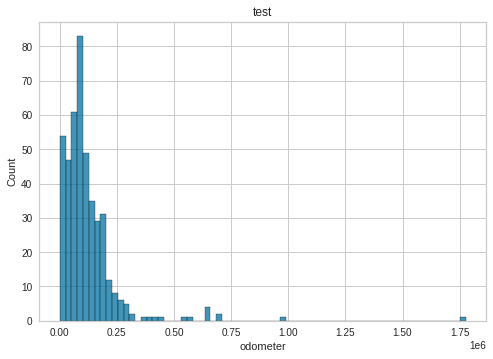

In [11]:
sns.histplot(train["odometer"])
plt.title("train")
plt.show()

sns.histplot(test["odometer"])
plt.title("test")
plt.show()

### year

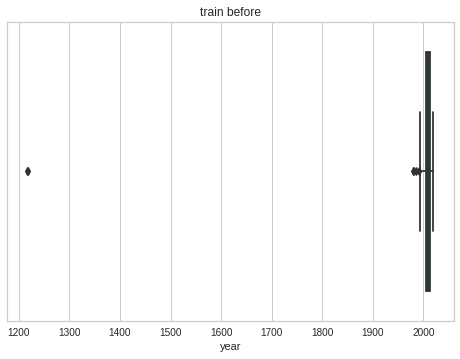

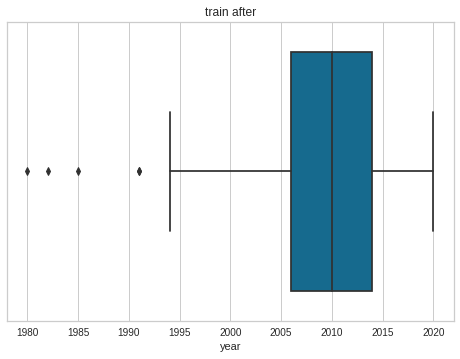

In [12]:
sns.boxplot(x="year", data=train)
plt.title("train before")
plt.show()

train = train[train["year"]>1900]

sns.boxplot(x="year", data=train)
plt.title("train after")
plt.show()

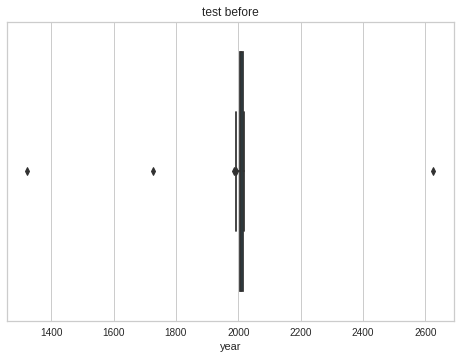

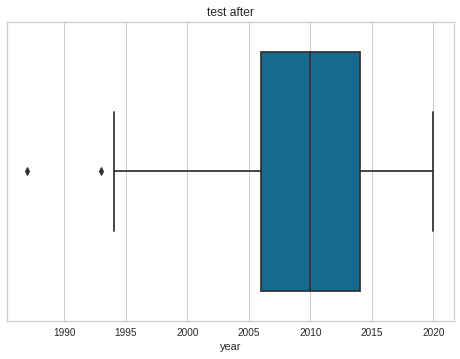

In [13]:
sns.boxplot(x="year", data=test)
plt.title("test before")
plt.show()

test["year"] = test["year"].apply(lambda x : train["year"].median() if x<1900 else x)
test["year"] = test["year"].apply(lambda x : train["year"].median() if x>2022 else x)

sns.boxplot(x="year", data=test)
plt.title("test after")
plt.show()

### title

In [14]:
def title(df):
    df["brand"] = df["title"].apply(lambda x : x.split(" ")[0])
    return df

train = title(train)
test = title(test)

train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,16.430348,Toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,17.312473,Toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,16.109559,Land
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,15.154451,Lexus
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,15.814961,Toyota


In [15]:
target_dict = dict(train.groupby(by="title").mean()["target"])

bins=20
target_dict = dict(pd.cut(pd.Series(target_dict), bins, labels=range(1, bins+1)))

train["title"] = [target_dict[k] for k in train["title"]]

temp=[]
for k in test["title"]:
    if k in target_dict:
        temp.append(target_dict[k])
    else:
        if "title" != "title":
            temp.append(np.mean(list(target_dict.values())))
        else:
            min = 30
            for s in list(target_dict.keys()):
                d = editdistance.eval(k, s)
                if min > d:
                    idx = s
                    min = d
            temp.append(target_dict[idx])

test["title"] = temp

len(target_dict)

201

In [16]:
target_dict = dict(train.groupby(by="brand").mean()["target"])

bins=20
target_dict = dict(pd.qcut(pd.Series(target_dict), bins, labels=range(1, bins+1)))

train["brand"] = [target_dict[k] for k in train["brand"]]

temp=[]
for k in test["brand"]:
    if k in target_dict:
        temp.append(target_dict[k])
    else:
        temp.append(np.mean(list(target_dict.values())))

test["brand"] = temp

len(target_dict)

41

### location

In [17]:
def location(df):
    df["location"] = df["location"].apply(lambda x : x.strip().lower())
    df["location"] = df["location"].apply(lambda x : "lagos" if "lagos" in x else x)
    df["location"] = df["location"].apply(lambda x : "lagos" if "mushin" in x else x)
    df["location"] = df["location"].apply(lambda x : "abuja" if "abuja" in x else x)
    df["location"] = df["location"].apply(lambda x : "abuja" if "fct" in x else x)
    df["location"] = df["location"].apply(lambda x : "ogun" if "ogun" in x else x)
    df["location"] = df["location"].apply(lambda x : "abia" if "abia" in x else x)
    df["location"] = df["location"].apply(lambda x : "other" if x not in ["lagos", "abuja", "ogun", "abia"] else x)
    return df

In [18]:
train = location(train)
train["location"].value_counts()

lagos    829
abuja    149
ogun      27
other      6
abia       2
Name: location, dtype: int64

In [19]:
test = location(test)
test["location"].value_counts()

lagos    355
abuja     69
ogun      10
other      1
abia       1
Name: location, dtype: int64

In [20]:
train, test = TargetEncoder("location", "median", train ,test)

{'abia': 14.356656727864781, 'abuja': 15.14125841921613, 'lagos': 15.35559839226358, 'ogun': 14.74570419500742, 'other': 14.734611378426322}


### isimported

In [21]:
train["isimported"].value_counts()

Foreign Used    744
Locally used    246
New              23
Name: isimported, dtype: int64

In [22]:
test["isimported"].value_counts()

Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

In [23]:
train, test = TargetEncoder("isimported", "mean", train, test)

{'Foreign Used': 15.573673127366614, 'Locally used': 14.631036709164453, 'New ': 17.2278246254569}


### engine

In [24]:
# def engine(df):
#     p1 = re.compile('[(]\D')
#     p2 = re.compile('\d*[)]')
#     df["engine_1"] = df["engine"].apply(lambda x : p1.search(x)[0][1:])
#     df["engine_2"] = df["engine"].apply(lambda x : p2.search(x)[0][:-1]).astype("int")
#     df["engine_1"] = df["engine_1"].apply(lambda x : "I" if x == "H" else x)
#     return df

In [25]:
train["engine"].value_counts()

4-cylinder(I4)    617
6-cylinder(V6)    221
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

In [26]:
test["engine"].value_counts()

4-cylinder(I4)      278
6-cylinder(V6)       89
6-cylinder(I6)       44
8-cylinder(V8)       21
5-cylinder(I5)        1
2-cylinder(I2)        1
12-cylinder(V12)      1
3-cylinder(I3)        1
Name: engine, dtype: int64

In [27]:
train = train.replace({
    '2-cylinder(I2)' : 1,
    '3-cylinder(I3)' : 1,
    '4-cylinder(I4)' : 1,
    '5-cylinder(I5)' : 1,
    '6-cylinder(I6)' : 1,
    '6-cylinder(V6)' : 2,
    '4-cylinder(H4)' : 3,
    '8-cylinder(V8)' : 3,
    '12-cylinder(V12)' : 4,
})

test = test.replace({
    '2-cylinder(I2)' : 1,
    '3-cylinder(I3)' : 1,
    '4-cylinder(I4)' : 1,
    '5-cylinder(I5)' : 1,
    '6-cylinder(I6)' : 1,
    '6-cylinder(V6)' : 2,
    '4-cylinder(H4)' : 3,
    '8-cylinder(V8)' : 3,
    '12-cylinder(V12)' : 4,
})

### transmission

In [28]:
train["transmission"].value_counts()

automatic    965
manual        48
Name: transmission, dtype: int64

In [29]:
test["transmission"].value_counts()

automatic    414
manual        22
Name: transmission, dtype: int64

In [30]:
train, test = TargetEncoder("transmission", "median", train, test)

{'automatic': 15.249403897883443, 'manual': 15.568184515757896}


### fuel

In [31]:
train["fuel"].value_counts()

petrol    970
diesel     43
Name: fuel, dtype: int64

In [32]:
test["fuel"].value_counts()

petrol    416
diesel     20
Name: fuel, dtype: int64

In [33]:
train, test = TargetEncoder("fuel", "median", train, test)

{'diesel': 15.66238932641341, 'petrol': 15.22283228627624}


### paint

In [34]:
def color(x):
    if (x.find('black') >= 0) or \
    (x.find('blac') >= 0):
        x = "black"
    if (x.find('white') >= 0) or \
    (x.find('cream') >= 0) or \
    (x.find('milk') >= 0):
        x = "white"
    if (x.find('silver') >= 0) or \
    (x.find('sliver') >= 0):
        x = "silver"
    if (x.find('grey') >= 0) or \
    (x.find('gray') >= 0) or \
    (x.find('gery') >= 0) or \
    (x.find('ash') >= 0):
        x = "grey"
    if (x.find('blue') >= 0) or \
    (x.find('purple') >= 0) or \
    (x.find('indigo ink pearl') >= 0):
        x = "blue"
    if (x.find('red') >= 0) or \
    (x.find('wine') >= 0) or \
    (x.find('whine') >= 0) or \
    (x.find('maroon') >= 0) or \
    (x.find('orange') >= 0):
        x = "red"
    if (x.find('gold') >= 0) or \
    (x.find('golf') >= 0) or \
    (x.find('yellow') >= 0):
        x = "gold"
    if x.find('green') >= 0:
        x = "green"
    if (x.find('brown') >= 0) or \
    (x.find('beige') >= 0):
        x = "brown"
    return x

def paint(df):
    df["paint"] = df["paint"].apply(lambda x : x.strip().lower())
    df["paint"] = df["paint"].apply(lambda x : color(x))
    return df

In [35]:
train = paint(train)
train["paint"].value_counts()

black     315
grey      165
white     154
silver    117
blue      106
red        72
gold       45
green      21
brown      18
Name: paint, dtype: int64

In [36]:
test = paint(test)
test["paint"].value_counts()

black     126
silver     67
white      64
grey       64
red        39
blue       38
green      16
gold       15
brown       7
Name: paint, dtype: int64

In [37]:
train, test = TargetEncoder("paint", "median", train, test)

{'black': 15.52298221066974, 'blue': 15.08240955762138, 'brown': 15.404693698729268, 'gold': 14.919113373213595, 'green': 14.868078908130977, 'grey': 15.149194968811868, 'red': 15.133244039657185, 'silver': 15.0139681816021, 'white': 15.640217213386848}


### Correlation

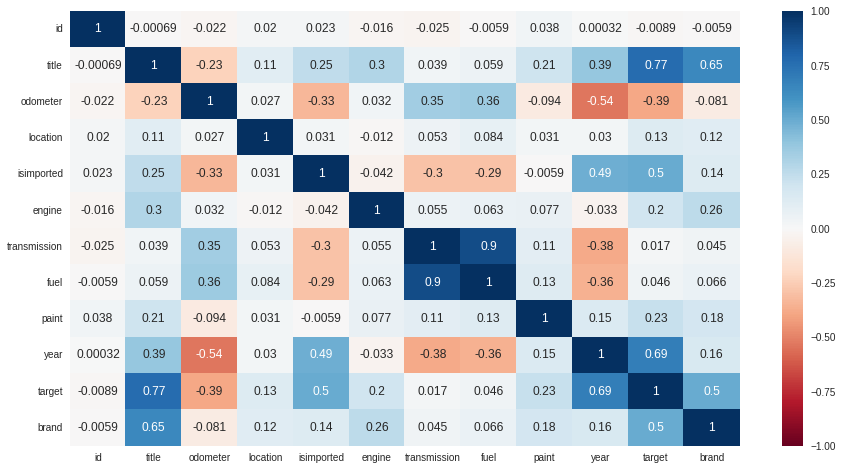

In [38]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [39]:
target_corr = np.abs(train.corr()["target"]).sort_values()
drop_corr = target_corr[target_corr.apply(lambda x : x < 0.1)]
drop_corr

id              0.008925
transmission    0.017179
fuel            0.046311
Name: target, dtype: float64

In [40]:
train = train.drop(["id", "transmission"], axis=1)
test = test.drop(["id", "transmission"], axis=1)

train.head()

,title,odometer,location,isimported,engine,fuel,paint,year,target,brand
0,9,18277,15.355598,15.573673,1,15.222832,15.133244,2016,16.430348,9
1,15,10,15.355598,17.227825,1,15.222832,15.522982,2019,17.312473,9
2,14,83091,15.355598,15.573673,2,15.222832,15.133244,2012,16.109559,19
3,9,91524,15.355598,15.573673,1,15.222832,15.149195,2007,15.154451,15
4,10,94177,15.355598,15.573673,2,15.222832,15.133244,2010,15.814961,9


## Training

### AutoML

In [41]:
s = setup(train, target='target',
          fold_strategy='kfold', fold=cv,
          use_gpu=True, normalize=True, normalize_method=scaler,
          numeric_features=['title', 'brand', 'engine', 'fuel'],
          session_id=seed, log_experiment=True)

,Description,Value
0,session_id,1011
1,Target,target
2,Original Data,"(1013, 10)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(709, 9)"


In [42]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

add_metric('NMAE', 'NMAE', NMAE, greater_is_better=False)

Name                                                       NMAE
Display Name                                               NMAE
Score Function                <function NMAE at 0x7f560b4497a0>
Scorer               make_scorer(NMAE, greater_is_better=False)
Target                                                     pred
Args                                                         {}
Greater is Better                                         False
Custom                                                     True
Name: NMAE, dtype: object

In [43]:
%%time

if ensemble == 'blending':
    blender = blend_models(compare_models(sort='NMAE', n_select=best_n), choose_better=True)
    tuned_blender = tune_model(blender, n_iter=tune_iter, optimize='NMAE', search_library='optuna', choose_better=True)
    final_model=finalize_model(tuned_blender)

if ensemble == 'stacking':
    stacker = stack_models(compare_models(sort='NMAE', n_select=best_n), choose_better=True)
    tuned_stacker = tune_model(stacker, n_iter=tune_iter, optimize='NMAE', search_library='optuna', choose_better=True)
    final_model=finalize_model(tuned_stacker)

final_model

,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
Fold,,,,,,,
0,0.2390,0.1106,0.3325,0.8855,0.0200,0.0153,0.0154
1,0.2257,0.0775,0.2784,0.9229,0.0173,0.0149,0.0147
2,0.1958,0.0698,0.2643,0.9272,0.0162,0.0127,0.0127
3,0.1851,0.0541,0.2327,0.9180,0.0145,0.0122,0.0121
4,0.2085,0.0813,0.2851,0.9219,0.0174,0.0135,0.0134
5,0.2213,0.0817,0.2858,0.9249,0.0175,0.0145,0.0145
6,0.2427,0.0994,0.3152,0.8935,0.0194,0.0158,0.0158
7,0.2234,0.0833,0.2887,0.9121,0.0178,0.0146,0.0146
8,0.2472,0.1232,0.3510,0.8414,0.0213,0.0160,0.0159


CPU times: user 5min 26s, sys: 49.1 s, total: 6min 16s
Wall time: 4min 53s


In [44]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Inference

In [45]:
predictions = predict_model(final_model, data=test)
prediction = predictions['Label']

In [46]:
submission = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/sample_submission.csv")
submission["target"] = np.exp(prediction).round().astype("int")
submission.to_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/submission.csv", index=False)

In [47]:
test = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/test.csv")
answer = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/answer.csv")
answer = pd.merge(test, answer, how="inner", left_on=list(test.columns[1:]), right_on=list(test.columns[1:]))["price"]

nmae_cheet=NMAE(answer, np.exp(prediction).round().astype("int"))
print("nmae_cheet: ", nmae_cheet)

wandb.log({'NMAE_cheet': nmae_cheet})

nmae_cheet:  0.30307008796241386
